In [263]:
import os
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
%matplotlib inline 

### Read in all csv files for analysis for Australia

In [264]:
#Load csv files
gdp = pd.read_csv("../Data/ProcessedData/GDP_selected_countries_cleaned.csv")
gdp_bar = pd.read_csv("../Data/ProcessedData/GDP_selected_countries_cleaned.csv")
cash_rate = pd.read_csv("../Data/ProcessedData/cashrate_cleaned.csv")
population = pd.read_csv("../Data/ProcessedData/Population_June_Cleaned.csv")
employment = pd.read_csv("../Data/ProcessedData/employment_cleaned.csv")
economy = pd.read_csv("../Data/ProcessedData/Economy_June_Cleaned.csv")
household_income = pd.read_csv("../Data/ProcessedData/Household_Income_cleaned.csv")

In [265]:
# Rename Year column
gdp_new = gdp.rename(columns={"Unnamed: 0": "Year"})
gdp_bar_new = gdp.rename(columns={"Unnamed: 0": "Year"})

# Set index for 1st df and convert Year to object for 2nd df
gdp_new.set_index("Year", inplace=True)
gdp_bar_new["Year"] = gdp_bar_new.Year.astype(str)
#gdp_drop_unnamed = gdp_new.loc[:, ~gdp_new.columns.str.contains('^Unnamed')]

## 

### What are the key factors driving GDP - demonstrate using CorrPlot


In [266]:
# Clean population data
del population["Unnamed: 0"]
population.head()

,Year,Births,Deaths,NaturalIncreases,InterstateArrivals,OverseasArrivals,OverseasDepartures,NetOverseasDepartures,NetOverseasMigration,EstimatedResidentPopulation,PercenChangeOverThePreviousYear
0,1995,64.3,31.5,32.8,96.0,50.5,32.7,32.7,23.8,18004.9,1.12
1,1996,62.0,31.7,30.3,84.8,49.9,34.2,34.2,20.6,18224.8,1.22
2,1997,63.6,31.4,32.2,90.0,49.5,38.9,38.9,6.1,18423.0,1.09
3,1998,62.3,31.8,30.5,89.4,54.1,45.6,45.6,8.5,18607.6,1.00
4,1999,62.7,32.2,30.5,89.2,55.6,40.8,40.8,14.8,18812.3,1.10


In [267]:
# Get data to run correlation
year = population[["Year"]]
gdp_aus_new = gdp_new[["Australia"]].reset_index(drop=True)

total_population = population[["EstimatedResidentPopulation"]]
total_employed = employment[["TotalEmployed"]]
total_employed_males = employment[["TotalEmployed_M"]]
total_employed_females = employment[["TotalEmployed_F"]]
total_unemployed = employment[["TotalUnemployed"]]
total_unemployed_males = employment[["TotalUnemployed_M"]]
total_unemployed_females = employment[["TotalUnemployed_F"]]

cash_rate_target = cash_rate[["Cash Rate Target"]]
overnight_cash_rate = cash_rate[["Interbank Overnight Cash Rate"]]
household_income_total = household_income[["TotalIncome"]]
household_savings_total = household_income[["TotalSavings"]]
net_savings = economy[["Net Savings"]]
gross_income = economy[["Total Use of Gross Income"]]

In [268]:
# Create df to correlate
correlation_df = pd.concat([gdp_aus_new,
                            total_population,
                            total_employed, 
                            total_employed_males,
                            total_employed_females,
                            total_unemployed,
                            total_unemployed_males,
                            total_unemployed_females,
                            cash_rate_target,
                            overnight_cash_rate,
                            household_income_total,
                            household_savings_total,
                            net_savings,
                            gross_income], axis=1)

# Rename to easy convention
correlation_renamed_df = correlation_df.rename(columns={"Australia": "Aus_GDP",
                                                        "EstimatedResidentPopulation": "Pop",
                                                        "TotalEmployed": "Tot Emp",
                                                        "TotalEmployed_M": "Tot Emp_M",
                                                        "TotalEmployed_F": "Tot Emp_F",
                                                        "TotalUnemployed": "Tot Unemp",
                                                        "TotalUnemployed_M": "Tot Unemp_M",
                                                        "TotalUnemployed_F": "Tot Unemp_F",
                                                        "Total Use of Gross Income": "Gross Income"})

#Check dataset
correlation_renamed_df.head()
correlation = correlation_renamed_df.corr()


Text(0.5, 1.0, 'Aus Economy')

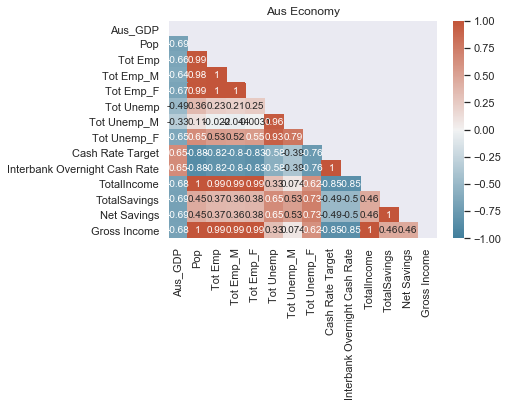

In [269]:
# Using Seaborn
matrix = np.triu(correlation)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
h = plt.axes()

plot = sns.heatmap(correlation, 
                   vmin=-1, 
                   vmax=1, 
                   annot=True,
                   cmap=cmap, 
                   mask=matrix)


sns.set(rc={'figure.figsize':(10,7)})
h.set_title('Aus Economy')

### 

### Prep for machine learning

In [270]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

In [271]:
correlation_renamed_df.describe()

,Aus_GDP,Pop,Tot Emp,Tot Emp_M,Tot Emp_F,Tot Unemp,Tot Unemp_M,Tot Unemp_F,Cash Rate Target,Interbank Overnight Cash Rate,TotalIncome,TotalSavings,Net Savings,Gross Income
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,3.051292,21395.592308,10407.003846,5686.434615,4720.569231,640.307692,351.638462,288.661538,4.232308,4.234615,249753.576923,3423.615385,3423.615385,249753.576923
std,1.108108,2431.524199,1486.017209,690.815742,796.300275,109.233907,65.879667,49.592306,2.043040,2.055962,103981.872560,11317.595604,11317.595604,103981.872560
min,-0.284839,18004.900000,8205.600000,4657.400000,3548.300000,459.000000,230.000000,226.200000,0.250000,0.140000,107093.000000,-5708.000000,-5708.000000,107093.000000
25%,2.341147,19329.825000,9061.625000,5024.750000,4036.875000,568.300000,308.225000,253.150000,2.562500,2.562500,152855.250000,-2152.500000,-2152.500000,152855.250000
50%,2.967610,21038.400000,10590.650000,5792.650000,4774.250000,653.100000,359.850000,280.800000,4.750000,4.750000,247583.500000,404.000000,404.000000,247583.500000
75%,3.908268,23388.800000,11538.025000,6226.600000,5311.500000,705.450000,386.275000,311.600000,5.500000,5.552500,341454.000000,7551.500000,7551.500000,341454.000000
max,5.073599,25698.100000,12889.700000,6833.600000,6056.100000,966.400000,513.400000,452.900000,7.500000,7.510000,423192.000000,52864.000000,52864.000000,423192.000000


### Linear Regression

In [272]:
correlation_renamed_df

,Aus_GDP,Pop,Tot Emp,Tot Emp_M,Tot Emp_F,Tot Unemp,Tot Unemp_M,Tot Unemp_F,Cash Rate Target,Interbank Overnight Cash Rate,TotalIncome,TotalSavings,Net Savings,Gross Income
0,3.837755,18004.9,8205.6,4657.4,3548.3,723.5,434.2,289.3,7.50,7.51,107093,313,313,107093
1,3.878585,18224.8,8311.7,4724.4,3587.3,723.8,424.3,299.5,7.50,7.51,113630,853,853,113630
2,3.966538,18423.0,8345.6,4731.9,3613.6,735.2,427.5,307.7,5.50,5.57,120328,1617,1617,120328
3,4.576689,18607.6,8516.8,4801.8,3715.0,702.8,419.9,282.9,5.00,5.07,124565,-1596,-1596,124565
4,5.073599,18812.3,8673.2,4897.8,3775.5,600.6,348.6,252.0,4.75,4.76,133049,-1208,-1208,133049
5,3.933137,19028.8,8922.0,4980.8,3941.2,564.3,327.3,237.0,6.00,6.00,142293,-5708,-5708,142293
6,1.930858,19274.7,9021.9,4996.6,4025.3,651.5,374.4,277.1,5.00,5.00,149872,1041,1041,149872
7,4.001404,19495.2,9180.8,5109.2,4071.6,619.7,348.2,271.5,4.72,4.72,161805,-2906,-2906,161805
8,2.985934,19720.7,9370.4,5155.4,4215.0,587.6,330.9,256.6,4.75,4.75,167707,-1506,-1506,167707
9,4.055452,19932.7,9543.3,5290.3,4253.0,537.3,294.0,243.3,5.25,5.25,186565,495,495,186565


In [273]:
# Define x and ay
data = correlation_renamed_df.drop(['Aus_GDP'], axis=1)
target = correlation_renamed_df['Aus_GDP']

# Do train-test split
data_train, data_test, target_train, target_test = train_test_split(data, 
                                                                    target,
                                                                    test_size=0.3,     
                                                                    random_state=101)

In [274]:
data.head()


,Pop,Tot Emp,Tot Emp_M,Tot Emp_F,Tot Unemp,Tot Unemp_M,Tot Unemp_F,Cash Rate Target,Interbank Overnight Cash Rate,TotalIncome,TotalSavings,Net Savings,Gross Income
0,18004.9,8205.6,4657.4,3548.3,723.5,434.2,289.3,7.50,7.51,107093,313,313,107093
1,18224.8,8311.7,4724.4,3587.3,723.8,424.3,299.5,7.50,7.51,113630,853,853,113630
2,18423.0,8345.6,4731.9,3613.6,735.2,427.5,307.7,5.50,5.57,120328,1617,1617,120328
3,18607.6,8516.8,4801.8,3715.0,702.8,419.9,282.9,5.00,5.07,124565,-1596,-1596,124565
4,18812.3,8673.2,4897.8,3775.5,600.6,348.6,252.0,4.75,4.76,133049,-1208,-1208,133049


In [275]:
# Load scalers
scaler = StandardScaler()

# Normalise scaling factors
data_train = scaler.fit_transform(data_train)
data_test = scaler.fit_transform(data_test)

In [276]:
# Define linear regression model
model_LinearRegression = LinearRegression()

# Train the model
model_LinearRegression.fit(data_train,
                           target_train)

LinearRegression()

In [277]:
# Make predictions
data_predict = model_LinearRegression.predict(data_test)
compare_pred_vs_acutal = pd.DataFrame({'Actual': target_test, 'Predicted': data_predict})
compare_pred_vs_acutal

,Actual,Predicted
24,2.160956,17.023078
22,2.300611,10.493835
23,2.949286,5.376565
20,2.192647,10.957676
10,3.204270,-1.826836
19,2.533115,9.937566
2,3.966538,-16.082447
7,4.001404,-10.979540


In [278]:
x = np.random.randint(3, size=(data_test.shape[0], data_test.shape[1]))
data_predict_x = model_LinearRegression.predict(x)
compare_x = pd.DataFrame({'Actual': target_test, 'Predicted': data_predict_x})
compare_x

,Actual,Predicted
24,2.160956,8069.156919
22,2.300611,17444.438369
23,2.949286,7788.552322
20,2.192647,8465.065760
10,3.204270,-7757.552394
19,2.533115,-4203.562093
2,3.966538,8129.823017
7,4.001404,-312.454011


Linear Regression Performance:

all features, Scaling:
MAE: 10.214142559479068
RMSE: 11.604187938521143
R2_Score:  -269.3601065576021


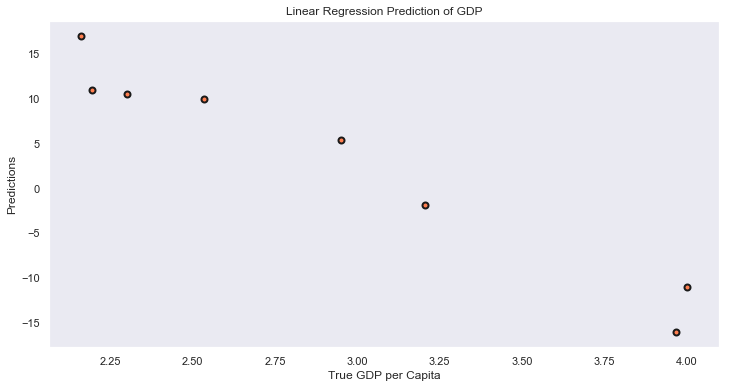

In [279]:
print('Linear Regression Performance:')
print('\nall features, Scaling:')
print('MAE:', metrics.mean_absolute_error(target_test, data_predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(target_test, data_predict)))
print('R2_Score: ', metrics.r2_score(target_test, data_predict))


fig = plt.figure(figsize=(12, 6))

plt.scatter(target_test,
            data_predict,
            color='coral',
            linewidths=2, 
            edgecolors='k')

plt.xlabel('True GDP per Capita') 
plt.ylabel('Predictions') 
plt.title('Linear Regression Prediction of GDP') 
plt.grid()
plt.show()

### 

### Support Vevtor Machine (SVM) learning model

In [280]:
# Load and train model
svm = SVR(kernel='rbf')
svm.fit(data_train,
        target_train)

SVR()

In [281]:
# Make predictions
svm_pred = svm.predict(data_test)

svm_pred_vs_acutal = pd.DataFrame({'Actual': target_test, 'Predicted': svm_pred})
svm_pred_vs_acutal

,Actual,Predicted
24,2.160956,2.717833
22,2.300611,2.404024
23,2.949286,2.512483
20,2.192647,2.352204
10,3.204270,3.639416
19,2.533115,2.406166
2,3.966538,3.752982
7,4.001404,3.942452


In [282]:
x = np.random.randint(3, size=(data_test.shape[0], data_test.shape[1]))

data_predict_x = svm.predict(x)
compare_x = pd.DataFrame({'Actual': target_test, 'Predicted': data_predict_x})
compare_x

,Actual,Predicted
24,2.160956,2.818617
22,2.300611,2.951962
23,2.949286,2.799580
20,2.192647,2.826294
10,3.204270,2.682418
19,2.533115,2.885791
2,3.966538,2.896990
7,4.001404,2.624508


In [283]:
print('Support Vector Machine (SVM) Performance:')

print('\nall features, with scaling:')
print('MAE:', metrics.mean_absolute_error(target_test, svm_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(target_test, svm_pred)))
print('R2_Score: ', metrics.r2_score(target_test, svm_pred))

Support Vector Machine (SVM) Performance:

all features, with scaling:
MAE: 0.26140650710431385
RMSE: 0.31456531435802004
R2_Score:  0.8013288673576433


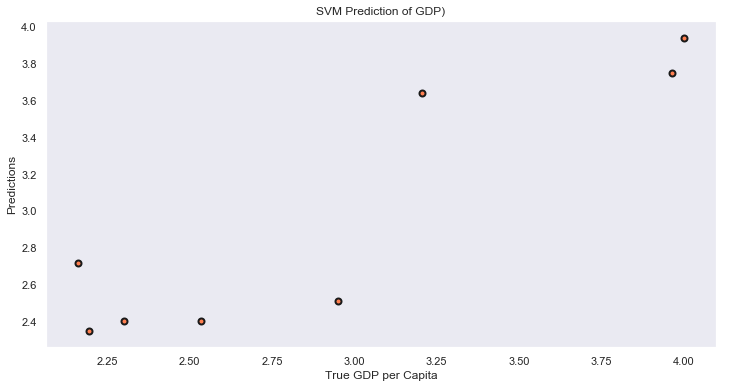

In [284]:
fig = plt.figure(figsize=(12, 6))

plt.scatter(target_test,
            svm_pred,
            color='coral',
            linewidths=2, 
            edgecolors='k')

plt.xlabel('True GDP per Capita') 
plt.ylabel('Predictions') 
plt.title('SVM Prediction of GDP)') 
plt.grid()
plt.show()

In [285]:
#Optimise parameters
param_grid = {'C': [1, 10, 100],
              'gamma': [0.01,0.001,0.0001],
              'kernel': ['rbf']} 

grid = GridSearchCV(SVR(),
                    param_grid,
                    refit=True,
                    verbose=3)

In [286]:
grid.fit(data_train,
         target_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.502 total time=   0.0s
[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.510 total time=   0.0s
[CV 3/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.348 total time=   0.0s
[CV 4/5] END ......C=1, gamma=0.01, kernel=rbf;, score=-0.183 total time=   0.0s
[CV 5/5] END ......C=1, gamma=0.01, kernel=rbf;, score=-1.596 total time=   0.0s
[CV 1/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.122 total time=   0.0s
[CV 2/5] END .....C=1, gamma=0.001, kernel=rbf;, score=-0.081 total time=   0.0s
[CV 3/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.087 total time=   0.0s
[CV 4/5] END .....C=1, gamma=0.001, kernel=rbf;, score=-0.624 total time=   0.0s
[CV 5/5] END .....C=1, gamma=0.001, kernel=rbf;, score=-0.928 total time=   0.0s
[CV 1/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.002 total time=   0.0s
[CV 2/5] END ....C=1, gamma=0.0001, kernel=rbf;, 

GridSearchCV(estimator=SVR(),
             param_grid={'C': [1, 10, 100], 'gamma': [0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [287]:
grid.best_params_

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}

In [288]:
grid.best_estimator_

SVR(C=100, gamma=0.0001)

In [289]:
grid_predictions = grid.predict(data_test)
grid_pred_vs_acutal = pd.DataFrame({'Actual': target_test, 'Predicted': grid_predictions})
grid_pred_vs_acutal

,Actual,Predicted
24,2.160956,2.930919
22,2.300611,2.812413
23,2.949286,2.904982
20,2.192647,2.545540
10,3.204270,4.034383
19,2.533115,2.568393
2,3.966538,3.812935
7,4.001404,4.013611


In [290]:
x = np.random.randint(3, size=(data_test.shape[0], data_test.shape[1]))

data_predict_x = grid.predict(x)
compare_x = pd.DataFrame({'Actual': target_test, 'Predicted': data_predict_x})
compare_x

,Actual,Predicted
24,2.160956,2.568310
22,2.300611,2.483504
23,2.949286,2.440838
20,2.192647,3.012842
10,3.204270,2.237325
19,2.533115,2.380345
2,3.966538,2.786366
7,4.001404,2.642371


MAE: 0.3387704376452682
RMSE: 0.4603472109601031
R2_Score:  0.5745151179680192


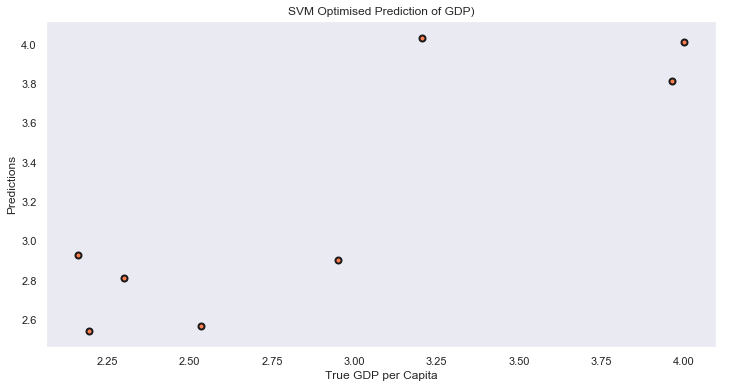

In [291]:
print('MAE:', metrics.mean_absolute_error(target_test, grid_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(target_test, grid_predictions)))
print('R2_Score: ', metrics.r2_score(target_test, grid_predictions))

fig = plt.figure(figsize=(12, 6))
plt.scatter(target_test,
            grid_predictions,
            color='coral', 
            linewidths=2, 
            edgecolors='k')

plt.xlabel('True GDP per Capita') 
plt.ylabel('Predictions') 
plt.title('SVM Optimised Prediction of GDP)') 
plt.grid()
plt.show()

### 

### Random Forest

In [292]:
# Build model and apply
random_forest = RandomForestRegressor(random_state=101, n_estimators=200)

random_forest.fit(data_train,
        target_train)

RandomForestRegressor(n_estimators=200, random_state=101)

In [293]:
# Make prediction
random_forest_pred = random_forest.predict(data_test)

random_forest_pred_vs_acutal = pd.DataFrame({'Actual': target_test, 'Predicted': random_forest_pred})
random_forest_pred_vs_acutal

,Actual,Predicted
24,2.160956,3.155008
22,2.300611,2.583821
23,2.949286,3.148605
20,2.192647,2.488985
10,3.204270,3.272211
19,2.533115,2.448018
2,3.966538,3.186091
7,4.001404,3.849596


In [294]:
x = np.random.randint(3, size=(data_test.shape[0], data_test.shape[1]))

data_predict_x = random_forest.predict(x)
compare_x = pd.DataFrame({'Actual': target_test, 'Predicted': data_predict_x})
compare_x

,Actual,Predicted
24,2.160956,2.115936
22,2.300611,1.893964
23,2.949286,2.576798
20,2.192647,2.098127
10,3.204270,2.547564
19,2.533115,2.853237
2,3.966538,2.442506
7,4.001404,2.305442


Random Forest Performance:

all features, No scaling:
MAE: 0.35727641972638496
RMSE: 0.47956888019409505
R2_Score:  0.5382412986472245


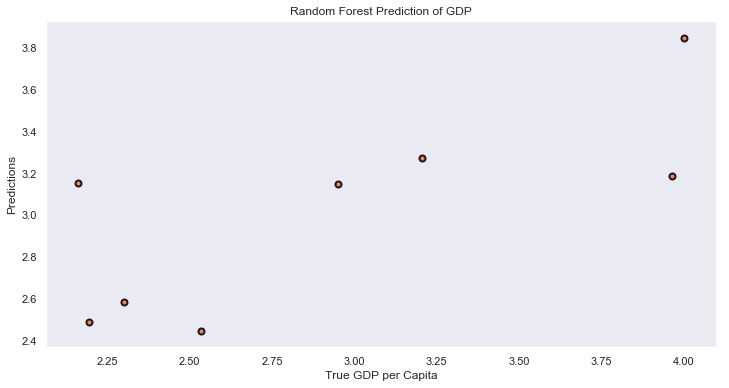

In [295]:
print('Random Forest Performance:')

print('\nall features, No scaling:')
print('MAE:', metrics.mean_absolute_error(target_test, random_forest_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(target_test, random_forest_pred)))
print('R2_Score: ', metrics.r2_score(target_test, random_forest_pred))


fig = plt.figure(figsize=(12, 6))
plt.scatter(target_test,
            random_forest_pred,
            color='coral',
            linewidths=2,
            edgecolors='k')

plt.xlabel('True GDP per Capita') 
plt.ylabel('Predictions') 
plt.title('Random Forest Prediction of GDP') 
plt.grid()
plt.show()

In [296]:
# Define parameters to optimise
rf_param_grid = {'max_features': ['sqrt', 'auto'],
                 'min_samples_leaf': [1, 3, 5],
                 'n_estimators': [100, 500, 1000],
                 'bootstrap': [False, True]}

In [297]:
# Get optimal parameters
rf_grid = GridSearchCV(estimator= RandomForestRegressor(), 
                       param_grid = rf_param_grid,
                       n_jobs=-1,
                       verbose=0)

In [298]:
# fit model
rf_grid.fit(data_train,
            target_train)

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [False, True],
                         'max_features': ['sqrt', 'auto'],
                         'min_samples_leaf': [1, 3, 5],
                         'n_estimators': [100, 500, 1000]})

In [299]:
# Get best parameters
rf_grid.best_params_

{'bootstrap': True,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'n_estimators': 100}

In [300]:
# Get best estimator
rf_grid.best_estimator_

RandomForestRegressor(max_features='sqrt')

In [301]:
# Run prediction and compare
rf_grid_predictions = rf_grid.predict(data_test)
rf_grid_pred_vs_acutal = pd.DataFrame({'Actual': target_test, 'Predicted': rf_grid_predictions})
rf_grid_pred_vs_acutal

,Actual,Predicted
24,2.160956,3.128146
22,2.300611,2.619261
23,2.949286,3.100544
20,2.192647,2.662927
10,3.204270,3.096883
19,2.533115,2.671211
2,3.966538,3.187208
7,4.001404,4.090973


In [302]:
x = np.random.randint(3, size=(data_test.shape[0], data_test.shape[1]))

data_predict_x = rf_grid.predict(x)
compare_x = pd.DataFrame({'Actual': target_test, 'Predicted': data_predict_x})
compare_x

,Actual,Predicted
24,2.160956,2.455966
22,2.300611,2.325088
23,2.949286,2.465322
20,2.192647,2.338353
10,3.204270,1.642854
19,2.533115,2.376812
2,3.966538,3.073081
7,4.001404,2.332278


MAE: 0.37772000648625037
RMSE: 0.4907921637538492
R2_Score:  0.5163754473736755


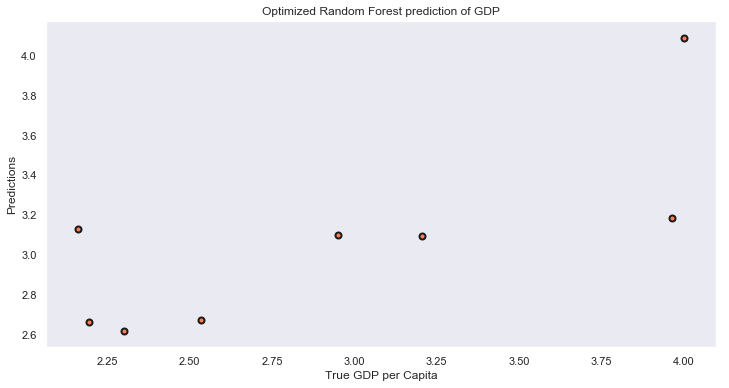

In [303]:
# Plot prediction vs actual values
print('MAE:', metrics.mean_absolute_error(target_test, rf_grid_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(target_test, rf_grid_predictions)))
print('R2_Score: ', metrics.r2_score(target_test, rf_grid_predictions))

fig = plt.figure(figsize=(12, 6))

plt.scatter(target_test,
            rf_grid_predictions,
            color='coral', 
            linewidths=2, 
            edgecolors='k')

plt.xlabel('True GDP per Capita') 
plt.ylabel('Predictions') 
plt.title('Optimized Random Forest prediction of GDP') 
plt.grid()
plt.show()

### 

### Gradient Boosting

In [304]:
gradient_boosting = GradientBoostingRegressor(learning_rate=0.1,
                                              n_estimators=100, 
                                              min_samples_split=2, 
                                              min_samples_leaf=1,
                                              max_depth=3,
                                              subsample=1.0,
                                              max_features= None,
                                              random_state=101)

gradient_boosting.fit(data_train, 
                      target_train)

GradientBoostingRegressor(random_state=101)

In [305]:
gradient_boosting_pred = gradient_boosting.predict(data_test)
gradient_boosting_pred_vs_acutal = pd.DataFrame({'Actual': target_test, 'Predicted': gradient_boosting_pred})
gradient_boosting_pred_vs_acutal

,Actual,Predicted
24,2.160956,2.851399
22,2.300611,2.243092
23,2.949286,2.846055
20,2.192647,1.950630
10,3.204270,2.687890
19,2.533115,1.941381
2,3.966538,2.205160
7,4.001404,3.866990


In [306]:
x = np.random.randint(3, size=(data_test.shape[0], data_test.shape[1]))

data_predict_x = gradient_boosting.predict(x)
compare_x = pd.DataFrame({'Actual': target_test, 'Predicted': data_predict_x})
compare_x

,Actual,Predicted
24,2.160956,2.802110
22,2.300611,1.992309
23,2.949286,2.162739
20,2.192647,2.700358
10,3.204270,1.632523
19,2.533115,2.702131
2,3.966538,2.878110
7,4.001404,1.874206


Gradiant Boosting Performance:

all features, No scaling:
MAE: 0.5121392759815617
RMSE: 0.7319974658874162
R2_Score:  -0.07580177439284053


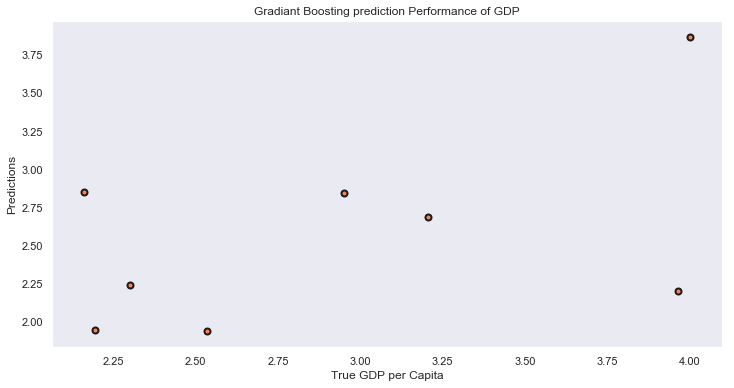

In [307]:
print('Gradiant Boosting Performance:')

print('\nall features, No scaling:')
print('MAE:', metrics.mean_absolute_error(target_test, gradient_boosting_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(target_test, gradient_boosting_pred)))
print('R2_Score: ', metrics.r2_score(target_test, gradient_boosting_pred))

fig = plt.figure(figsize=(12, 6))
plt.scatter(target_test,
            gradient_boosting_pred,
            color='coral', 
            linewidths=2, 
            edgecolors='k')

plt.xlabel('True GDP per Capita') 
plt.ylabel('Predictions') 
plt.title('Gradiant Boosting prediction Performance of GDP') 
plt.grid()
plt.show()

In [308]:
# Extract important features from the model
feat_imp = pd.Series(gradient_boosting.feature_importances_, list(data.columns)).sort_values(ascending=False)

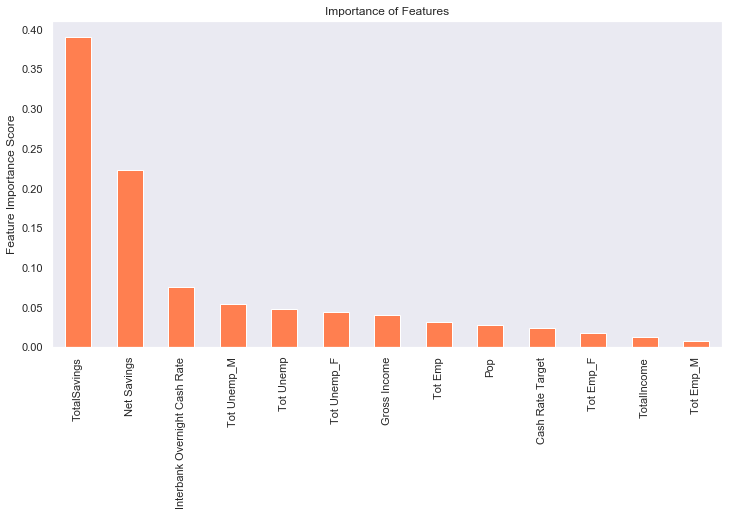

In [309]:
fig = plt.figure(figsize=(12, 6))

feat_imp.plot(kind='bar',
              title='Importance of Features', 
              color= 'coral')

plt.ylabel('Feature Importance Score')
plt.grid()
plt.show()

In [310]:
gradient_boosting_param_grid = {'learning_rate':[1, 0.1, 0.01, 0.001], 
                                'n_estimators':[100, 500, 1000],
                                'max_depth':[3, 5, 8],
                                'subsample':[0.7, 1], 
                                'min_samples_leaf':[1, 20],
                                'min_samples_split':[10, 20],
                                'max_features':[4, 7]}

gbm_tuning = GridSearchCV(estimator =GradientBoostingRegressor(random_state=101),
                          param_grid = gradient_boosting_param_grid,
                          n_jobs=-1,
                          cv=5)

gbm_tuning.fit(data_train,
               target_train)

print(gbm_tuning.best_params_)

{'learning_rate': 0.01, 'max_depth': 3, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 1}


In [311]:
gbm_grid_predictions = gbm_tuning.predict(data_test)
gbm_grid_pred_vs_acutal = pd.DataFrame({'Actual': target_test, 'Predicted': gbm_grid_predictions})
gbm_grid_pred_vs_acutal

,Actual,Predicted
24,2.160956,3.207922
22,2.300611,2.745107
23,2.949286,3.219589
20,2.192647,2.468584
10,3.204270,3.027027
19,2.533115,2.468584
2,3.966538,3.240680
7,4.001404,3.741365


In [312]:
x = np.random.randint(3, size=(data_test.shape[0], data_test.shape[1]))

data_predict_x = gbm_tuning.predict(x)
compare_x = pd.DataFrame({'Actual': target_test, 'Predicted': data_predict_x})
compare_x

,Actual,Predicted
24,2.160956,2.202786
22,2.300611,2.256086
23,2.949286,2.150035
20,2.192647,2.138926
10,3.204270,2.401486
19,2.533115,2.246054
2,3.966538,2.138926
7,4.001404,2.183991


MAE: 0.40817151242639876
RMSE: 0.5090417588899145
R2_Score:  0.4797406154993128


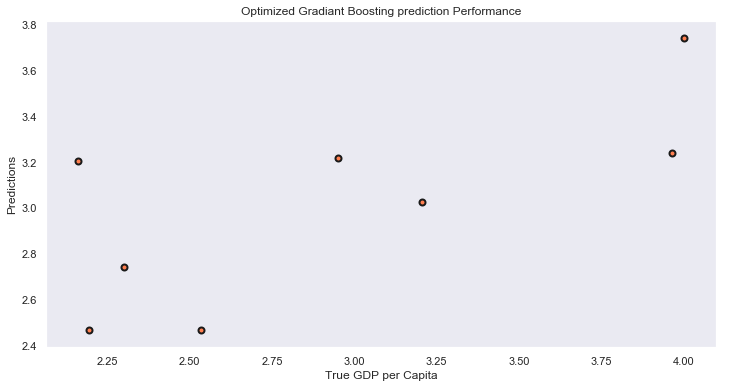

In [313]:
print('MAE:', metrics.mean_absolute_error(target_test, gbm_grid_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(target_test, gbm_grid_predictions)))
print('R2_Score: ', metrics.r2_score(target_test, gbm_grid_predictions))

fig = plt.figure(figsize=(12, 6))

plt.scatter(target_test,
            gbm_grid_predictions,
            color='coral',
            linewidths=2,
            edgecolors='k')

plt.xlabel('True GDP per Capita') 
plt.ylabel('Predictions') 
plt.title('Optimized Gradiant Boosting prediction Performance') 
plt.grid()
plt.show()

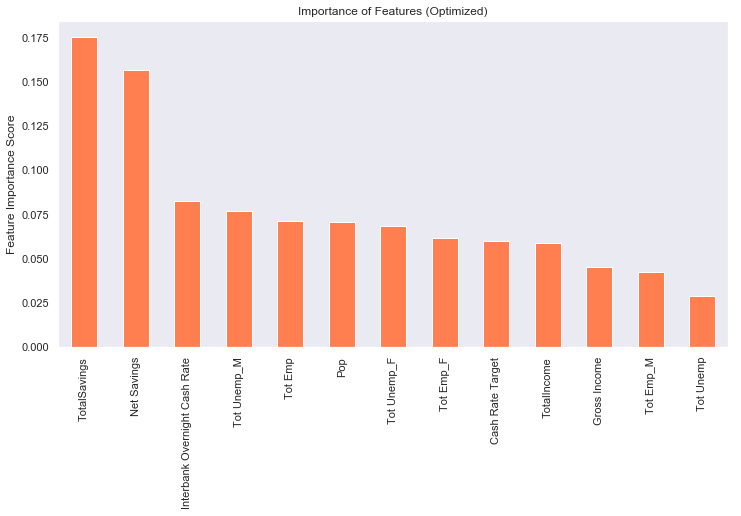

In [314]:
gbm_opt = GradientBoostingRegressor(learning_rate=0.01,
                                    n_estimators=500,
                                    max_depth=5, 
                                    min_samples_split=10,
                                    min_samples_leaf=1, 
                                    subsample=0.7,
                                    max_features=7, 
                                    random_state=101)

gbm_opt.fit(data_train, target_train)

feat_imp2 = pd.Series(gbm_opt.feature_importances_, list(data.columns)).sort_values(ascending=False)
fig = plt.figure(figsize=(12, 6))
feat_imp2.plot(kind='bar', title='Importance of Features (Optimized)', color= 'coral')
plt.ylabel('Feature Importance Score')
plt.grid()
plt.show()